# **PROJECT 1 : GROUP 6(MA YINCHU)**
# JAPAN 

## **DELIVERABLES**


In [16]:
%pip install wbdata
%pip install pandas-datareader

import numpy as np
import pandas as pd
import wbdata
from pandas_datareader import wb
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## 1. [A] Population Statistics 

In this section, we define our population function. It first uses helper functions to retrieve population data from the World Bank API for specific countries, years,age groups, and genders. Since the World Bank reports population data in a 5 year age range, our function calculates population for custom age ranges by determining how much of each 5 year bin overlaps with the user input and divide. It also handles the 80+ age group sepreately and combines male and female population count for aged people 12-30 in 2004 Japan.

In [17]:
class PopulationDataError(ValueError):
    pass

def _wb_get_value(place, indicator, year):
    place = place.strip().upper()
    indicator = indicator.strip()
    year = int(year)

    df = wb.download(indicator=indicator, country=place, start=year, end=year)
    if df is None or df.empty:
        return None

    val = df.iloc[0][indicator]
    if pd.isna(val):
        return None
    return float(val)

def _age_group_indicator(low, high, sex):
    suffix = "MA" if sex == "males" else "FE"
    return f"SP.POP.{low:02d}{high:02d}.{suffix}"

def _age_80_plus_indicator(sex):
    return "SP.POP.80UP.MA" if sex == "males" else "SP.POP.80UP.FE"

def population(year, sex, age_range, place):
    if not isinstance(year, int):
        raise PopulationDataError("year must be an int")

    if not isinstance(age_range, tuple) or len(age_range) != 2:
        raise PopulationDataError("age_range must be (low, high)")

    low, high = age_range
    if not (isinstance(low, int) and isinstance(high, int)):
        raise PopulationDataError("age_range values must be ints")

    if low < 0 or high < 0 or high < low:
        raise PopulationDataError("age_range must satisfy 0 <= low <= high")

    sex = sex.strip().lower()
    if sex not in ("people", "males", "females"):
        raise PopulationDataError("sex must be 'people', 'males', or 'females'")

    place = place.strip().upper()
    if not place:
        raise PopulationDataError("place must be a World Bank code like 'JPN' or 'WLD'")

    def one_sex_total(one_sex):
        total = 0.0

        if high >= 80:
            if low > 80:
                raise PopulationDataError("low > 80 not supported (80+ is a single bin)")
            ind80 = _age_80_plus_indicator(one_sex)
            v80 = _wb_get_value(place, ind80, year)
            if v80 is None:
                raise PopulationDataError(f"missing data: {place}, {year}, {ind80}")
            total += v80
            high_effective = 79
        else:
            high_effective = high

        for start in range(0, 80, 5):
            end = start + 4

            overlap_low = max(low, start)
            overlap_high = min(high_effective, end)
            if overlap_low > overlap_high:
                continue

            ind = _age_group_indicator(start, end, one_sex)
            bin_value = _wb_get_value(place, ind, year)
            if bin_value is None:
                raise PopulationDataError(f"missing data: {place}, {year}, {ind}")

            years_covered = overlap_high - overlap_low + 1
            total += bin_value * (years_covered / 5.0)

        return total

    if sex == "people":
        total_value = one_sex_total("males") + one_sex_total("females")
    else:
        total_value = one_sex_total(sex)

    return int(round(total_value))

PLACE_MAP = {"japan": "JPN", "world": "WLD"}

def population_from_query(query):
    parts = re.findall(r"\[(.*?)\]", query, flags=re.DOTALL)
    if len(parts) != 5:
        raise ValueError("Query must have 5 bracketed fields: [year], [sex], [low], [high], [place]")

    year = int(parts[0].strip())
    sex = parts[1].strip().lower()
    low = int(parts[2].strip())
    high = int(parts[3].strip())

    place_raw = re.sub(r"\s+", " ", parts[4].strip().lower())
    place = PLACE_MAP.get(place_raw, place_raw.upper())

    return population(year, sex, (low, high), place)

def ask(query):
    print(population_from_query(query))

In [18]:
ask("In [2004] how many [people] aged [12] to [30] were living in [Japan]?")

/tmp/ipykernel_297/457664933.py:9: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = wb.download(indicator=indicator, country=place, start=year, end=year)
/tmp/ipykernel_297/457664933.py:9: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = wb.download(indicator=indicator, country=place, start=year, end=year)
/tmp/ipykernel_297/457664933.py:9: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = wb.download(indicator=indicator, country=place, start=year, end=year)
/tmp/ipykernel_297/457664933.py:9: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions expl

28319362


/tmp/ipykernel_297/457664933.py:9: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = wb.download(indicator=indicator, country=place, start=year, end=year)
/tmp/ipykernel_297/457664933.py:9: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = wb.download(indicator=indicator, country=place, start=year, end=year)


# 3.[A] Population DataFrames

In [19]:
## creating age bins

age_ranges = []

for i in np.arange(0, 80, 5):
    age_ranges.append({'code': f"{i:02d}{i + 4:02d}", 
                       'label': f"{i} - {i + 4}"
                      })
    
age_ranges.append({'code': '80UP', 
                   'label': '80+'})
print(age_ranges)

[{'code': '0004', 'label': '0 - 4'}, {'code': '0509', 'label': '5 - 9'}, {'code': '1014', 'label': '10 - 14'}, {'code': '1519', 'label': '15 - 19'}, {'code': '2024', 'label': '20 - 24'}, {'code': '2529', 'label': '25 - 29'}, {'code': '3034', 'label': '30 - 34'}, {'code': '3539', 'label': '35 - 39'}, {'code': '4044', 'label': '40 - 44'}, {'code': '4549', 'label': '45 - 49'}, {'code': '5054', 'label': '50 - 54'}, {'code': '5559', 'label': '55 - 59'}, {'code': '6064', 'label': '60 - 64'}, {'code': '6569', 'label': '65 - 69'}, {'code': '7074', 'label': '70 - 74'}, {'code': '7579', 'label': '75 - 79'}, {'code': '80UP', 'label': '80+'}]


In [20]:
## separating by sex

male_variables = {f"SP.POP.{b['code']}.MA": f"Males {b['label']}" for b in age_ranges}
female_variables = {f"SP.POP.{b['code']}.FE": f"Females {b['label']}" for b in age_ranges}

variables = {}

variables.update(male_variables)
variables.update(female_variables)

print(variables)

{'SP.POP.0004.MA': 'Males 0 - 4', 'SP.POP.0509.MA': 'Males 5 - 9', 'SP.POP.1014.MA': 'Males 10 - 14', 'SP.POP.1519.MA': 'Males 15 - 19', 'SP.POP.2024.MA': 'Males 20 - 24', 'SP.POP.2529.MA': 'Males 25 - 29', 'SP.POP.3034.MA': 'Males 30 - 34', 'SP.POP.3539.MA': 'Males 35 - 39', 'SP.POP.4044.MA': 'Males 40 - 44', 'SP.POP.4549.MA': 'Males 45 - 49', 'SP.POP.5054.MA': 'Males 50 - 54', 'SP.POP.5559.MA': 'Males 55 - 59', 'SP.POP.6064.MA': 'Males 60 - 64', 'SP.POP.6569.MA': 'Males 65 - 69', 'SP.POP.7074.MA': 'Males 70 - 74', 'SP.POP.7579.MA': 'Males 75 - 79', 'SP.POP.80UP.MA': 'Males 80+', 'SP.POP.0004.FE': 'Females 0 - 4', 'SP.POP.0509.FE': 'Females 5 - 9', 'SP.POP.1014.FE': 'Females 10 - 14', 'SP.POP.1519.FE': 'Females 15 - 19', 'SP.POP.2024.FE': 'Females 20 - 24', 'SP.POP.2529.FE': 'Females 25 - 29', 'SP.POP.3034.FE': 'Females 30 - 34', 'SP.POP.3539.FE': 'Females 35 - 39', 'SP.POP.4044.FE': 'Females 40 - 44', 'SP.POP.4549.FE': 'Females 45 - 49', 'SP.POP.5054.FE': 'Females 50 - 54', 'SP.POP.5

In [31]:
## dataframe function

def population_df(countries, start, end):
    df = wb.download(
        indicator=list(variables.keys()),   # <-- FIX: list, not dict
        country=countries,
        start=start,
        end=end
    )
    df = df.rename(columns=variables)
    df = df.sort_index()
    return df

pop = population_df(['USA'], start = 2000, end = 2020)
pop.head()

/tmp/ipykernel_297/3147915857.py:4: FutureWarning:

errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead



Males 0 - 4  Males 5 - 9  Males 10 - 14  Males 15 - 19  \
country       year                                                           
United States 2000      9771939     10335718       10553412       10509013   
              2001      9843473     10185442       10741746       10606063   
              2002      9926071     10047860       10862596       10667781   
              2003     10004990      9952683       10902135       10752048   
              2004     10087732      9925601       10861255       10887805   

                    Males 20 - 24  Males 25 - 29  Males 30 - 34  \
country       year                                                
United States 2000       10113115       10099438       10681709   
              2001       10381773        9934971       10716510   
              2002       10593144        9908339       10684970   
              2003       10753678       10017439       10581542   
              2004       10873838       10188229       10448447   

                    Males 35 - 39  Males 40 - 44  Males 45 - 49  ...  \
country       year                                               ...   
United States 2000       11685873       11434350       10101752  ...   
              2001       11490531       11612386       10376690  ...   
              2002       11243072       11725204       10645567  ...   
              2003       10995463       11746971       10889716  ...   
              2004       10800389       11722118       11098720  ...   

                    Females 35 - 39  Females 40 - 44  Females 45 - 49  \
country       year                                                      
United States 2000         11230889         11275581         10162194   
              2001         11025682         11372211         10453769   
              2002         10780925         11433366         10722137   
              2003         10534846         11423398         10945036   
              2004         10337589         11384371         11127657   

                    Females 50 - 54  Females 55 - 59  Females 60 - 64  \
country       year                                                      
United States 2000          8950669          6977396          5596457   
              2001          9240314          7291983          5740996   
              2002          9399388          7710777          5984973   
              2003          9572435          8080769          6285001   
              2004          9818989          8439182          6561036   

                    Females 65 - 69  Females 70 - 74  Females 75 - 79  \
country       year                                                      
United States 2000          5030856          4783926          4247941   
              2001          5030189          4740535          4249963   
              2002          5054830          4695425          4231361   
              2003          5120835          4638729          4208188   
              2004          5215139          4609271          4179263   

                    Females 80+  
country       year               
United States 2000      6030376  
              2001      6131239  
              2002      6240916  
              2003      6339001  
              2004      6446416  

[5 rows x 34 columns]

# 4.[B]Population Pyramids

In [32]:
## population pyramid function

def _age_sort_key(label):
    s = str(label)
    num = ''
    for character in s:
        if character.isdigit():
            num += character
        elif num:
            break
    return int(num) if num else 9999

def population_pyramid(df, country = None, year = None, title = None, ax = None):
    if country is not None and year is not None:
        row = df.loc[(country, str(year))]
    else:
        row = df.iloc[0]

    male_cols = [c for c in row.index if str(c).startswith('Males ')]
    female_cols = [c for c in row.index if str(c).startswith('Females ')]

    if len(male_cols) == 0 or len(female_cols) == 0:
        raise ValueError('No columns starting with Males and Females')

    def age_label(column_name, prefix):
        return str(column_name)[len(prefix):]

    male_map = {age_label(c, 'Males '): c for c in male_cols}
    female_map = {age_label(c, 'Females '): c for c in female_cols}

    ages = sorted(set(male_map.keys()) & set(female_map.keys()), key = _age_sort_key)

    males = np.array([row[male_map[a]] if a in male_map else np.nan for a in ages], dtype=float)
    females = np.array([row[female_map[a]] if a in female_map else np.nan for a in ages], dtype=float)

    scale = 1e6
    males = males/scale
    females = females/scale

    males_plot = -males
    females_plot = females

    if ax is None:
        fig, ax = plt.subplots(figsize = (7, 6))

    y = np.arange(len(ages))
    ax.barh(y, males_plot, label = "Males")
    ax.barh(y, females_plot, label = "Females")

    ax.set_yticks(y)
    ax.set_yticklabels(ages)

    max_val = max(np.nanmax(males_plot), np.nanmax(females_plot)) if len(ages) else 1
    ax.set_xlim(-max_val * 1.1, max_val * 1.1)
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{abs(int(x))}"))

    ax.axvline(0, linewidth=1)

    ax.set_xlabel("Population (millions)")
    ax.set_ylabel("Age group")

    if title is None:
        if country is not None:
            title = f"{country} Population Pyramid"
        else:
            title = "Population Pyramid"
    ax.set_title(title)

    ax.legend()
    return ax

# 7. [C] Other Visualization Tools

**Birth Rate VS Death Rate**

In [33]:
variable_labels = {"SP.POP.TOTL":"JPN Population", 
                   "SP.POP.3539.FE": "Population ages 35-39, female", 
                   "SP.POP.3034.FE": "Population ages 30-34, female", 
                   "SP.POP.2529.FE": "Population ages 25-29, female",
                   "SP.DYN.TFRT.IN": "Fertility rate", 
                   "SP.POP.3539.MA": "Population ages 35-39, male", 
                   "SP.POP.3034.MA": "Population ages 30-34, male", 
                   "SP.POP.2529.MA": "Population ages 25-29, male", 
                   "SP.POP.2024.MA": "Population ages 20-24, male", 
                   "SP.POP.GROW": "Population growth (annual %)", 
                   "SH.DYN.MORT": "Mortality rate, under-5 (per 1,000 live births)",
                   "SP.DYN.CBRT.IN": "Birth rate, crude (per 1,000 people)"}       
JPN = wbdata.get_dataframe(variable_labels, country="JPN")
JPN.index = JPN.index.astype(int)

In [34]:
birth_mortality = JPN[['Birth rate, crude (per 1,000 people)', 'Mortality rate, under-5 (per 1,000 live births)']].sort_index()
birth_mortality

,"Birth rate, crude (per 1,000 people)","Mortality rate, under-5 (per 1,000 live births)"
date,,
1960,17.2,39.7
1961,16.9,36.2
1962,17.0,32.9
1963,17.3,29.8
1964,17.7,27.0
...,...,...
2020,6.8,2.4
2021,6.6,2.4
2022,6.3,2.4


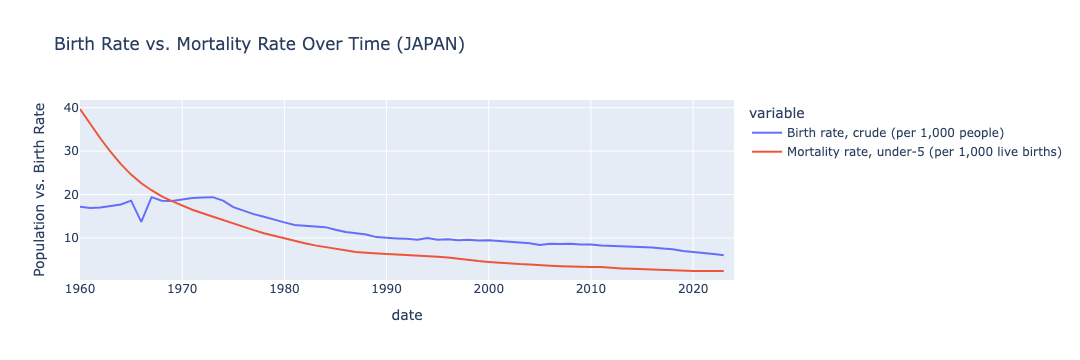

In [35]:
import plotly.express as px

px.line(
    birth_mortality,
    title="Birth Rate vs. Mortality Rate Over Time (JAPAN)",
    labels={"value": "Population vs. Birth Rate", "index": "Time"}
)

## 2.[A] Unit Tests

## This section of Unit Testing verifies that all of our deliverable functions work properly.

In [37]:
import unittest
import pandas as pd
import numpy as np
from unittest.mock import patch

# -----------------------
# Mock wb.download (no network)
# -----------------------
def _mock_value_for_indicator(indicator: str) -> float:
    """
    Deterministic fake World Bank values for testing.
    - Male 5-year bins: 100
    - Female 5-year bins: 200
    - Male 80UP: 1000
    - Female 80UP: 2000
    """
    ind = indicator.upper()

    if "80UP" in ind and ind.endswith(".MA"):
        return 1000.0
    if "80UP" in ind and ind.endswith(".FE"):
        return 2000.0

    if ind.endswith(".MA"):
        return 100.0
    if ind.endswith(".FE"):
        return 200.0

    # if you ever call a different indicator in tests:
    return 0.0

def _mock_wb_download(indicator, country, start, end):
    """
    Mimics pandas_datareader.wb.download output format:
    index = MultiIndex(country, year-as-string), columns = indicators.
    """
    # normalize to list of indicators
    if isinstance(indicator, dict):
        # This is exactly the "wrong" call pattern you had before.
        # We fail fast so the unit test catches it.
        raise TypeError("indicator must be a string or list of strings, not a dict")

    indicators = [indicator] if isinstance(indicator, str) else list(indicator)

    # normalize to list of countries
    countries = [country] if isinstance(country, str) else list(country)

    years = list(range(int(start), int(end) + 1))
    idx = pd.MultiIndex.from_product([countries, [str(y) for y in years]])

    data = {}
    for ind in indicators:
        data[ind] = [_mock_value_for_indicator(ind)] * len(idx)

    return pd.DataFrame(data, index=idx)

# -----------------------
# Unit tests
# -----------------------
class TestPopulationFunctions(unittest.TestCase):

    @patch.object(wb, "download", side_effect=_mock_wb_download)
    def test_wb_get_value_normal(self, _):
        v = _wb_get_value("JPN", "SP.POP.1014.MA", 2004)
        self.assertEqual(v, 100.0)

    @patch.object(wb, "download", side_effect=_mock_wb_download)
    def test_wb_get_value_empty_returns_none(self, _):
        # override mock to return empty df for this test
        def empty_download(indicator, country, start, end):
            return pd.DataFrame()

        with patch.object(wb, "download", side_effect=empty_download):
            v = _wb_get_value("JPN", "SP.POP.1014.MA", 2004)
            self.assertIsNone(v)

    def test_age_group_indicator_format(self):
        self.assertEqual(_age_group_indicator(10, 14, "males"), "SP.POP.1014.MA")
        self.assertEqual(_age_group_indicator(0, 4, "females"), "SP.POP.0004.FE")

    def test_age_80_plus_indicator(self):
        self.assertEqual(_age_80_plus_indicator("males"), "SP.POP.80UP.MA")
        self.assertEqual(_age_80_plus_indicator("females"), "SP.POP.80UP.FE")

    def test_population_validation_year(self):
        with self.assertRaises(PopulationDataError):
            population("2004", "people", (0, 4), "JPN")

    def test_population_validation_age_range(self):
        with self.assertRaises(PopulationDataError):
            population(2004, "people", [0, 4], "JPN")
        with self.assertRaises(PopulationDataError):
            population(2004, "people", (5, 4), "JPN")
        with self.assertRaises(PopulationDataError):
            population(2004, "people", (-1, 4), "JPN")

    def test_population_validation_sex(self):
        with self.assertRaises(PopulationDataError):
            population(2004, "male", (0, 4), "JPN")

    def test_population_validation_place(self):
        with self.assertRaises(PopulationDataError):
            population(2004, "people", (0, 4), "   ")

    @patch.object(wb, "download", side_effect=_mock_wb_download)
    def test_population_weighted_bins_no_80plus(self, _):
        # Age range 12–30 spans partial bins:
        # 10–14 contributes 3/5
        # 15–19 contributes 5/5
        # 20–24 contributes 5/5
        # 25–29 contributes 5/5
        # 30–34 contributes 1/5
        # Total fraction = 3/5 + 1 + 1 + 1 + 1/5 = 3.8
        # Male bin value=100 => 380
        # Female bin value=200 => 760
        # People => 1140
        out = population(2004, "people", (12, 30), "JPN")
        self.assertEqual(out, 1140)

        out_m = population(2004, "males", (12, 30), "JPN")
        self.assertEqual(out_m, 380)

        out_f = population(2004, "females", (12, 30), "JPN")
        self.assertEqual(out_f, 760)

    @patch.object(wb, "download", side_effect=_mock_wb_download)
    def test_population_handles_80plus(self, _):
        # Age range 78–85:
        # 75–79 contributes 78–79 => 2/5 of the bin
        # plus 80UP fully
        # Male: (2/5)*100 + 1000 = 40 + 1000 = 1040
        out_m = population(2004, "males", (78, 85), "JPN")
        self.assertEqual(out_m, 1040)

        # Female: (2/5)*200 + 2000 = 80 + 2000 = 2080
        out_f = population(2004, "females", (78, 85), "JPN")
        self.assertEqual(out_f, 2080)

        # People: 3120
        out_p = population(2004, "people", (78, 85), "JPN")
        self.assertEqual(out_p, 3120)

    @patch.object(wb, "download", side_effect=_mock_wb_download)
    def test_population_from_query_place_map(self, _):
        # Uses PLACE_MAP for "Japan" -> JPN
        q = "In [2004] how many [people] aged [12] to [30] were living in [Japan]?"
        self.assertEqual(population_from_query(q), 1140)

    def test_population_from_query_bad_format(self):
        with self.assertRaises(ValueError):
            population_from_query("In [2004] how many [people] in [Japan]?")  # not 5 fields

class TestPopulationDF(unittest.TestCase):

    @patch.object(wb, "download", side_effect=_mock_wb_download)
    def test_population_df_uses_list_of_indicators(self, _):
        # This test is designed to fail if population_df passes indicator=variables (dict)
        df = population_df(["USA"], start=2000, end=2001)
        self.assertIsInstance(df, pd.DataFrame)
        self.assertFalse(df.empty)

        # columns should be renamed to readable labels if you used variables mapping
        # so at least one should start with "Males" or "Females"
        self.assertTrue(any(str(c).startswith(("Males", "Females")) for c in df.columns))

# Run tests
unittest.main(argv=[""], verbosity=2, exit=False)

test_population_df_uses_list_of_indicators (__main__.TestPopulationDF.test_population_df_uses_list_of_indicators) ... ok
test_age_80_plus_indicator (__main__.TestPopulationFunctions.test_age_80_plus_indicator) ... ok
test_age_group_indicator_format (__main__.TestPopulationFunctions.test_age_group_indicator_format) ... ok
test_population_from_query_bad_format (__main__.TestPopulationFunctions.test_population_from_query_bad_format) ... ok
test_population_from_query_place_map (__main__.TestPopulationFunctions.test_population_from_query_place_map) ... ok
test_population_handles_80plus (__main__.TestPopulationFunctions.test_population_handles_80plus) ... ok
test_population_validation_age_range (__main__.TestPopulationFunctions.test_population_validation_age_range) ... ok
test_population_validation_place (__main__.TestPopulationFunctions.test_population_validation_place) ... ok
test_population_validation_sex (__main__.TestPopulationFunctions.test_population_validation_sex) ... ok
test_popula